## Load and preprocess data, then calculate the number of unique algorithmic and non-algorithmic sellers.


In [91]:
import pandas as pd
import numpy as np

df = pd.read_csv('cleaned_data.csv')
##Transform Time Coulumn to Time Format
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")

##Transform CrawlTime Column to Fortmat
df['crawlTime'] = pd.to_datetime(df['crawlTime'])

## Exclude all Rows where condition isnt New and which where a reactive Crawl
df = df[df['trigByReactive'] != True]
df = df[df['condition'].isin(['Neu', 'New'])]

##Get the Number of Distinct Values
distinct_values_verkäufer = df['sellerName'].unique()
print(f"Es gibt insgesamt {len(distinct_values_verkäufer)} verschiedene Verkäufer")

##Read in the Sellers who are algorithmic
df_algorithmic_seller_names = pd.read_csv('df_algorithmic_seller_names.csv')
df_algorithmic_seller_names = df_algorithmic_seller_names.rename(columns={'AlgorithmicSellerNames': 'sellerName'})  # rename column


# Create a new column to indicate if the seller is algorithmic or not
df['is_algorithmic'] = df['sellerName'].isin(df_algorithmic_seller_names['sellerName'])

# Calculate the number of algorithmic and non-algorithmic sellers
num_algo_sellers = df[df['is_algorithmic']]['sellerName'].nunique()
num_non_algo_sellers = df[~df['is_algorithmic']]['sellerName'].nunique()

print(f"Es gibt insgesamt {num_non_algo_sellers} Non-Algo Verkäufer")
print(f"Es gibt insgesamt {num_algo_sellers} Algo Verkäufer")
print(f"Sie Summieren sich richtig auf",num_algo_sellers + num_non_algo_sellers == len(distinct_values_verkäufer))



Es gibt insgesamt 1966 verschiedene Verkäufer
Es gibt insgesamt 1552 Non-Algo Verkäufer
Es gibt insgesamt 414 Algo Verkäufer
Sie Summieren sich richtig auf True


## Determine the number of unique ASINs associated with Amazon and non-Amazon sellers, and verify if their sum matches the total unique ASINs in the dataset.

In [92]:
amazon_asin_values = df.loc[df['sellerName'].isin(['amazon', 'Amazon Warehouse ', 'Amazon US', 'Amazon UK']), 'asin'].unique()
print(f"An so vielen Asins ist Amazon als Verkäufer eingetragen:{len(amazon_asin_values)}")

# Assuming the DataFrame is named 'df'
all_asin_values = df['asin'].unique()

# Subtract the values that exist in the 'amazon_asin_values' list
non_amazon_asin_values = set(all_asin_values) - set(amazon_asin_values)
print(f"An so vielen Asins ist Amazon nicht als Verkäufer eingetragen:{len(non_amazon_asin_values)}")
print(f"So Viele unterschiedliche Asins gibt es maximal {len(all_asin_values)}")

# Create a DataFrame with only Amazon-sold products
amazon_df = df[df['asin'].isin(amazon_asin_values)]
# Create a DataFrame with only non-Amazon-sold products
non_amazon_df = df[df['asin'].isin(non_amazon_asin_values)]
# Calculate the number of unique ASINs in each data frame
amazon_unique_asins = len(amazon_df['asin'].unique())
non_amazon_unique_asins = len(non_amazon_df['asin'].unique())

print(f"Sie Summieren sich richtig auf", amazon_unique_asins + non_amazon_unique_asins == len(all_asin_values))


An so vielen Asins ist Amazon als Verkäufer eingetragen:661
An so vielen Asins ist Amazon nicht als Verkäufer eingetragen:313
So Viele unterschiedliche Asins gibt es maximal 974
Sie Summieren sich richtig auf True


## Create a New Dataframe. The dataframe contains asins where at least 2 Algo Sellers exist. Print out the length of the Dataframe, or the Number of asins

In [105]:
# Group the original dataframe by 'asin'
grouped_df_for_asins = df.groupby('asin')

# Define a function to filter groups with at least 3 distinct algorithmic sellers
def filter_at_least_three_algo_sellers(group):
    distinct_sellers = group['sellerName'].unique()
    algo_seller_count = np.sum(np.isin(distinct_sellers, df_algorithmic_seller_names['sellerName']))
    return algo_seller_count >= 3

# Apply the function to the grouped data and save the results in a new DataFrame
three_algo_sellers_df = grouped_df_for_asins.filter(filter_at_least_three_algo_sellers)

# Get the unique ASINs in the new DataFrame
unique_asins_with_three_algo_sellers = three_algo_sellers_df['asin'].unique()

# Print the length of the DataFrame or the number of ASINs
print(f"Number of ASINs with at least 3 Algo Sellers: {len(unique_asins_with_three_algo_sellers)}")

# Print each ASIN and its associated algorithmic sellers
#for asin in unique_asins_with_three_algo_sellers:
 #   asin_df = three_algo_sellers_df[three_algo_sellers_df['asin'] == asin]
  #  algo_sellers = asin_df[asin_df['sellerName'].isin(df_algorithmic_seller_names['sellerName'])]['sellerName'].unique()
    #print(f"-------------")
    #print(f"ASIN: {asin}, Algorithmic Sellers: {', '.join(algo_sellers)}")

# Save the unique ASINs with at least 3 algorithmic sellers to a new DataFrame
asins_three_algo_sellers_df = pd.DataFrame(unique_asins_with_three_algo_sellers, columns=['asin'])

# Save the DataFrame to a CSV file
asins_three_algo_sellers_df.to_csv('asins_with_three_algo_sellers.csv', index=False)

print("ASINs with at least 3 algorithmic sellers saved to 'asins_with_three_algo_sellers.csv'")


Number of ASINs with at least 3 Algo Sellers: 408
ASINs with at least 3 algorithmic sellers saved to 'asins_with_three_algo_sellers.csv'


# Create a New Dataframe. The Dataframe contains asins where one algo and one none algo Seller exists

In [94]:
## Zeitlicher Verlauf bei Non-Amazon Produkten

# Step 1: Group non_amazon_df by 'asin' and 'time'
amazon_df = amazon_df.groupby(['asin'])

# Step 2: Define a function to filter groups with at least one algorithmic and one non-algorithmic seller
def filter_mixed_sellers(group):
    algorithmic_present = group['sellerName'].isin(df_algorithmic_seller_names['sellerName']).any()
    non_algorithmic_present = group['sellerName'].isin(df_non_algorithmic_seller_names['sellerName']).any()
    return algorithmic_present and non_algorithmic_present

# Step 3: Apply the function to the grouped data and save the results in a new DataFrame
mixed_sellers_df_amazon_products = amazon_df.filter(filter_mixed_sellers)

In [95]:
# define a function to extract hour from datetime column
def get_hour(datetime_val):
    return datetime_val.hour

# apply the get_hour function to the 'time' column using apply method
mixed_sellers_df_amazon_products['hourTime'] = mixed_sellers_df_amazon_products['time'].apply(get_hour)


In [102]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import random

# Step 1: Filter the ASINs with a range of 4-5 sellers
asin_seller_counts = mixed_sellers_df_amazon_products.groupby('asin')['sellerName'].nunique()
filtered_asins = asin_seller_counts[(asin_seller_counts >= 3) & (asin_seller_counts <= 5)].index

# Step 2: Select a random ASIN from the filtered ASINs
random_asin = random.choice(filtered_asins)

# Step 3: Filter the DataFrame for the selected ASIN
asin_specific_df = mixed_sellers_df_amazon_products[mixed_sellers_df_amazon_products['asin'] == random_asin].copy()

# assuming your original dataframe is called 'asin_specific_df'
selected_cols = ['time','crawlTime','asin','price', 'sellerName', 'hourTime']
asin_specific_df = asin_specific_df[selected_cols]
# swap hourTime values that are equal to 0 with 24
asin_specific_df.loc[asin_specific_df['hourTime'] == 0, 'hourTime'] = 24

# sort the dataframe by hourTime in descending order
asin_specific_df_sorted = asin_specific_df.sort_values(by=['hourTime'], ascending=True)

# display the sorted dataframe as an HTML table
#HTML(asin_specific_df_sorted.to_html(index=False))
asin = asin_specific_df['asin'].unique()

C:\Users\Robert Betschinger\AppData\Local\Temp\ipykernel_9348\3007220296.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = asin_specific_df.groupby(['time', 'sellerName']).mean().reset_index()


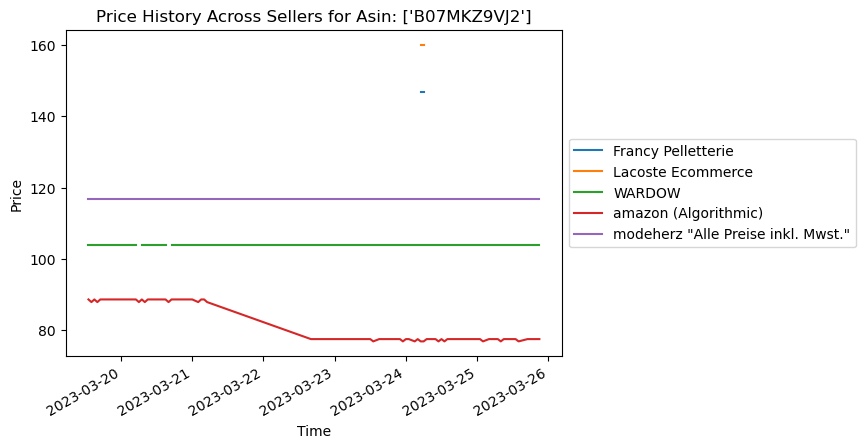

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# assuming your dataframe is called 'asin_specific_df'
selected_cols = ['price', 'sellerName', 'time','crawlTime']
asin_specific_df = asin_specific_df[selected_cols]

# ensure 'time' column is in datetime64[ns] format
asin_specific_df['time'] = pd.to_datetime(asin_specific_df['time'])

# group the data by time and sellerName and calculate the average price
grouped_df = asin_specific_df.groupby(['time', 'sellerName']).mean().reset_index()

# add seller type to sellerName
grouped_df['sellerName'] = grouped_df['sellerName'].apply(
    lambda x: f"{x} (Algorithmic)" if x in df_algorithmic_seller_names['sellerName'].values else f"{x}"
)

# pivot the table to get a separate column for each seller
pivot_df = grouped_df.pivot(index='time', columns='sellerName', values='price')

# plot the price history for each seller
pivot_df.plot(kind='line')

# set the x-axis label
plt.xlabel('Time')

# set the y-axis label
plt.ylabel('Price')

# set the plot title
plt.title(f'Price History Across Sellers for Asin: {asin}')

# move legend to the right
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# show the plot
plt.show()
